# Linear track demo

Here we load sorted unit data obtained from MatClust to identify putative place cells. The session has about 15 minutes of linear track running, followed by 15 minutes of rest. 

Data was recorded by Joshua Chu, with a Spikegadgets wireless headstage, on July 8th, 2017, from the CA! area of a male Long-Evans rat named `install`.

Notebook was created by Etienne Ackermann.

## 1. Obtain example data

We will look for data in the `example-data\linear-track\` directory inside your current working directory. If the data doesn't exist, we will download it from https://github.com/nelpy/example-data, and save it to your local machine. 

If you already have the data, it won't be downloaded again.

In particular, we will download two files, namely
 1. `trajectory.videoPositionTracking` which is a binary file with (x,y) position coordinate pairs and timestamps, and
 2. `spikes.mat` which is a Matlab file containing information about sorted units (cells) obtained by using MatClust (https://bitbucket.org/mkarlsso/matclust).

In [1]:
import os
import requests

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

datadir = os.path.join(os.getcwd(), 'example-data\linear-track')
os.makedirs(datadir, exist_ok=True)

filenames = []
filenames.append(os.path.join(datadir, 'trajectory.videoPositionTracking'))
filenames.append(os.path.join(datadir, 'spikes.mat'))
urls = []
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/trajectory.videoPositionTracking')
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/spikes.mat')

for filename, url in zip(filenames, urls):
    if os.path.exists(filename):
        print('you already have the example data, skipping download...')
    else:
        print('downloading data from {}'.format(url))
        # Streaming, so we can iterate over the response.
        r = requests.get(url, stream=True)

        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0)); 
        chunk_size = 1024 # number of bytes to process at a time (NOTE: progress bar unit only accurate if this is 1 kB)

        with open(filename, 'wb+') as f:
            for data in tqdm(r.iter_content(chunk_size), total=int(total_size/chunk_size), unit='kB'):
                f.write(data)
            
        print('data saved to local directory {}'.format(filename))

filename_pos = filenames[0]
filename_spikes = filenames[1]

you already have the example data, skipping download...
you already have the example data, skipping download...


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

```
<Start settings>\n
threshold: 199\n
dark: 0\n
clockrate: 30000\n
camera resolution: 640x480\n
pixel scale: 0 pix/cm\n
Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n
<End settings>\n
```

In [3]:
def print_header(filename, timeout=50):
    """Reads header lines from a SpikeGadgets .rec file, and prints it to screen."""
    linecount = 0
    with open(filename, 'rb') as fileobj:
        instr = fileobj.readline()
        linecount += 1
        while (instr != b'<End settings>\n') :
            print(instr)
            instr = fileobj.readline()
            if linecount > timeout:
                break
    print(instr)

In [4]:
print_header(filename_pos)

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'
b'<End settings>\n'


In [5]:
n_packets = 500000
timestamps = []
x1 = []
y1 = []
x2 = []
y2 = []
ii = 0
with open(filename_pos, 'rb') as fileobj:
    instr = fileobj.readline()
    while (instr != b'<End settings>\n') :
        print(instr)
        instr = fileobj.readline()
    for packet in iter(lambda: fileobj.read(12), ''):
        if packet:
            ts_ = struct.unpack('<L', packet[0:4])[0]
            x1_ = struct.unpack('<H', packet[4:6])[0]
            y1_ = struct.unpack('<H', packet[6:8])[0]
            x2_ = struct.unpack('<H', packet[8:10])[0]
            y2_ = struct.unpack('<H', packet[10:12])[0]
            timestamps.append(ts_)
            x1.append(x1_)
            y1.append(y1_)
            x2.append(x2_)
            y2.append(y2_)
        else:
            break
        if ii >= n_packets:
            print('Stopped before reaching end of file')
            break

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'


# Get session boundaries and trajectory objects

In [32]:
# we estimate large periods of inactivity as periods where the animal's estimated position did not move for at least 10 seconds
minLength = 600 # 10 seconds @ 60 fps
bounds, _, _ = nel.utils.get_events_boundaries(np.gradient(x1), PrimaryThreshold=0, SecondaryThreshold=0, mode='below', minLength=minLength, ds=1)

FS = 30000
bounds_ts = np.zeros(bounds.shape)
for row in range(len(bounds)):
    for col in range(2):
        bounds_ts[row,col] = timestamps[bounds[row,col]]
        
rest = nel.EpochArray(bounds_ts/FS, domain=nel.EpochArray((timestamps[0]/FS, timestamps[-1]/FS)))
session_epochs = (rest.expand(20)+~rest)
session_epochs._sort()

In [39]:
for ep in session_epochs:
    print(ep.duration)

1:05:823 minutes
15:59:115 minutes
17:17:485 minutes


In [7]:
rest

<EpochArray at 0x1d4f92370b8: 2 epochs> of duration 17:03:308 minutes

In [8]:
~rest

<EpochArray at 0x1d4f921b470: 1 epoch> of duration 15:59:115 minutes

In [9]:
session_epochs.time

array([[ 4377.0317    ,  4442.85523333],
       [ 4422.85523333,  5381.9703    ],
       [ 5361.9703    ,  6399.4556    ]])

In [10]:
pos = nel.AnalogSignalArray(np.vstack((x1, y1)), timestamps=np.array(timestamps)/FS, support=(~rest).shrink(20), fs=60)

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


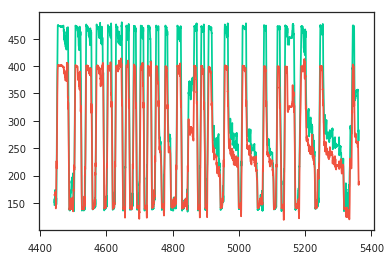

In [11]:
npl.plot(pos.simplify())

In [12]:
pos.support

<EpochArray at 0x1d4fcbda828: 1 epoch> of duration 15:19:115 minutes

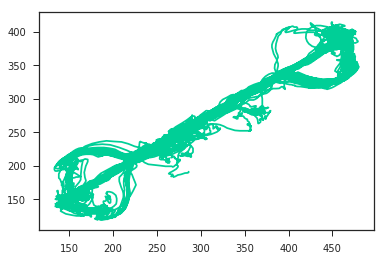

In [13]:
npl.plot2d(pos.simplify(n_points=20000))

(100, 500)

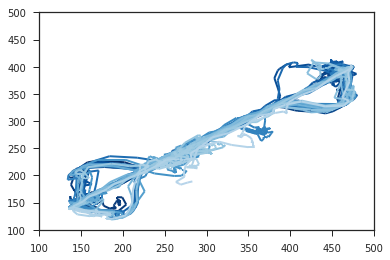

In [14]:
tvals, yvals = pos.simplify(n_points=5000).asarray()
npl.colorline(yvals[0,:], yvals[1,:])
ax = plt.gca()
ax.set_xlim(100,500)
ax.set_ylim(100,500)


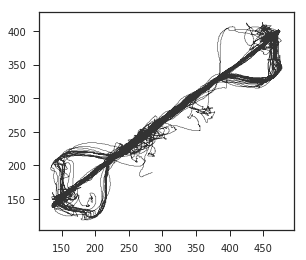

In [15]:
ax = npl.plot2d(pos.smooth(sigma=0.1), lw=0.5, color='0.2')
ax.set_aspect('equal')


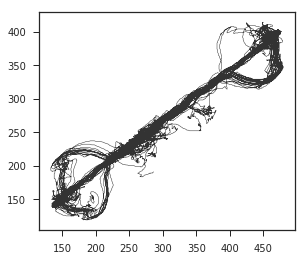

In [16]:
ax = npl.plot2d(pos, lw=0.5, color='0.2')
ax.set_aspect('equal')


In [17]:
from sklearn.decomposition import PCA

In [18]:
X = pos._ydata_colsig

In [19]:
pca = PCA(n_components=1)
Xlinear = pca.fit_transform(X)
Xlinear = Xlinear - np.min(Xlinear)
Xlinear = (Xlinear / np.max(Xlinear))*100
pos1d = nel.AnalogSignalArray(Xlinear, timestamps=pos.time, support=pos.support)

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:113: UserWarning: fs was not specified, so we try to estimate it from the data...
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:115: UserWarning: fs was estimated to be 60.000000000873115 Hz


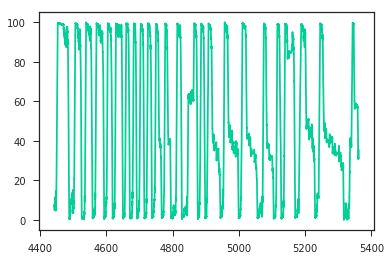

In [20]:
npl.plot(pos1d)

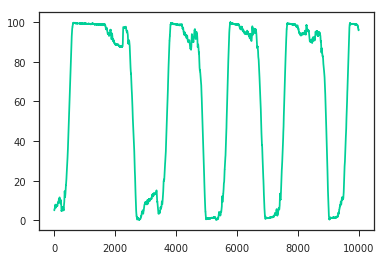

In [21]:
plt.plot(Xlinear[:10000])

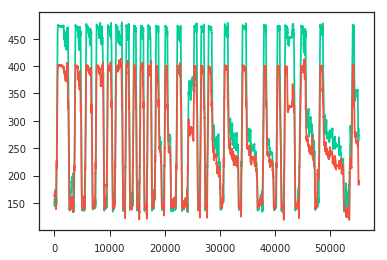

In [22]:
plt.plot(X)

In [23]:
Xlinear_ = pca.inverse_transform(Xlinear)

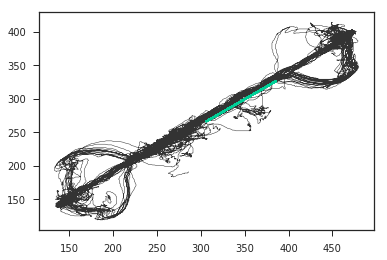

In [24]:
plt.plot(X[:,0], X[:,1], lw=0.5, color='0.2')
plt.plot(Xlinear_[:,0], Xlinear_[:,1])


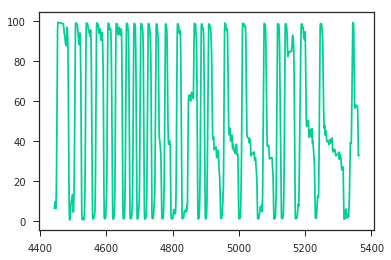

In [25]:
ax = npl.plot(pos1d.smooth(sigma=0.5))
# ax.set_xlim(200,800)

In [26]:
mat = nel.io.matlab.load(filename_spikes)

In [27]:
mat['spikes'][0].shape

(22,)

In [28]:
# Epoch for which spikes were sorted
session_bounds = nel.EpochArray(mat['spikes'][9][0]['timerange'].ravel()[0])

## Find spike times of sorted cells

In [29]:
spikes = []
ct = 0
num_array = 0
for ii, array in enumerate(mat['spikes']):
    # If empty array, that particular tetrode was not sorted
    if (array.size > 1):
        for jj, subarray in enumerate(array):
            if (subarray.size != 0):
                # Exclude tetrodes with no spikes
                if (len(subarray['time'].ravel()[0]) != 0):
                    spikes.append(subarray['time'].ravel()[0])
                    ct +=1
    elif (array.size == 1):
        if (len(array['time'].ravel()[0]) != 0):
            spikes.append(array['time'].ravel()[0])
            ct +=1
print("Found {} non-empty units total".format(ct))

Found 31 non-empty units total


In [29]:
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=FS)
st.support

<EpochArray at 0x137a178eeb8: 1 epoch> of duration 32:48:273 minutes

In [30]:
rest.domain

<EpochArray at 0x1379b817080: 1 epoch> of duration 33:02:423 minutes

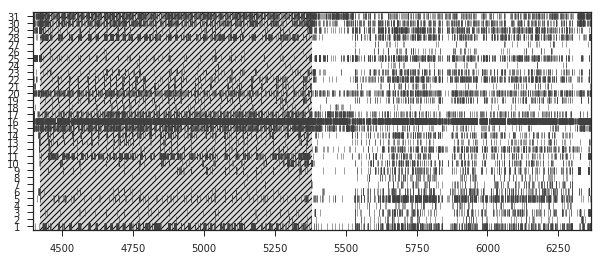

In [31]:
with npl.FigureManager(show=True, figsize=(10,4)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.epochplot(~rest, alpha=0.3)
    ax.set_xlim(*session_bounds.time)

In [32]:
sigma_100ms = 0.1
speed1 = nel.utils.dxdt_AnalogSignalArray(pos1d, smooth=True, sigma=sigma_100ms)

In [33]:
run_epochs = nel.utils.get_run_epochs(speed1, v1=5,v2=3) # original choice
run_epochs = nel.utils.get_run_epochs(speed1, v1=8,v2=8) # more aggressive choice

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


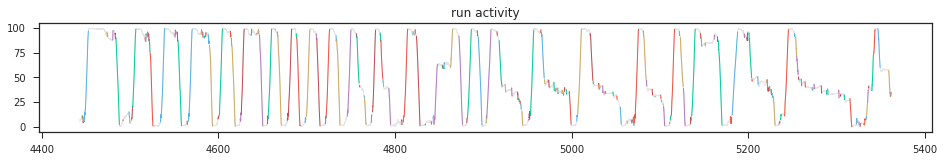

In [34]:
with npl.FigureManager(show=True, figsize=(16,2)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    plt.plot(pos1d.time, pos1d.asarray().yvals, lw=1, alpha=0.2, color='gray')
    npl.plot(pos1d[run_epochs], ax=ax, lw=1, label='run')
    
    plt.title('run activity')

In [35]:
st_run = st[run_epochs]

In [36]:
ds_run = 0.5 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 0.2 # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_run, extern=pos1d, n_extern=50, extmin=0, extmax=100, sigma=sigma, min_duration=1)

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified


In [37]:
tc = tc.reorder_units()

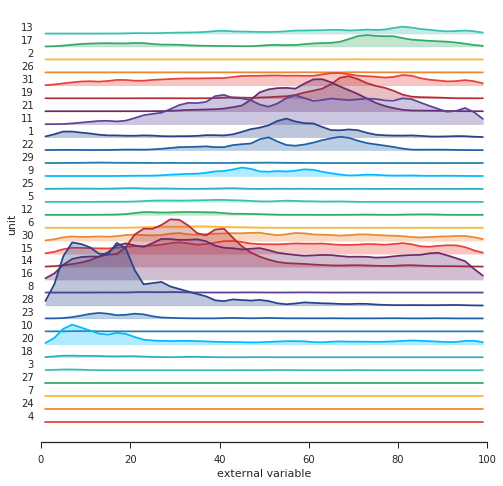

In [38]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=False, pad=3)

### Restrict subset of cells (units) to use for subsequent decoding and/or analysis

Here we may request to use
1. unimodal cells only,
1. pyramidal cells only,
1. active cells only,
1. any combination of the above, and other criteria

Here we only impose a minimum peak firing rate of 1.5 Hz, and we reject putative interneurons by imposing a maximum average firing rate of 5 Hz averaged over the entire track.

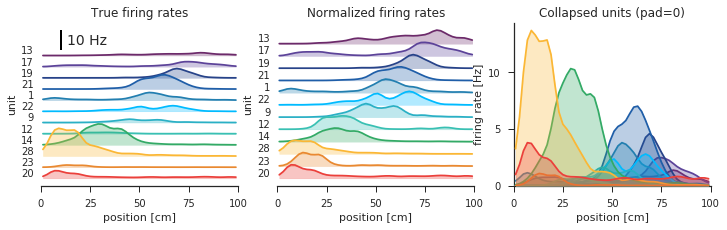

In [39]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 3.5 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))


# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = st._unit_subset(unit_ids_to_keep)

tc = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc.reorder_units(inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(12,3)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 63), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been sp

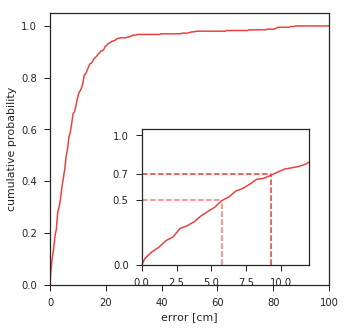

In [40]:
with npl.FigureManager(show=True, figsize=(5,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    ds_run = 0.5 # 100 ms
    ds_1ms = 0.01
#     st_run = st[run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds_1ms).smooth(sigma=0.5, inplace=True).rebin(w=ds_run/ds_1ms)
    
    bst = bst_run

    cumhist, bincenters = nel.decoding.cumulative_dist_decoding_error_using_xval(bst, extern=pos1d, extmax=100)
    npl.plot_cum_error_dist(bst=bst, extern=pos1d, extmin=0, extmax=100);
    
#     npl.utils.savefig('cum_error.svg')

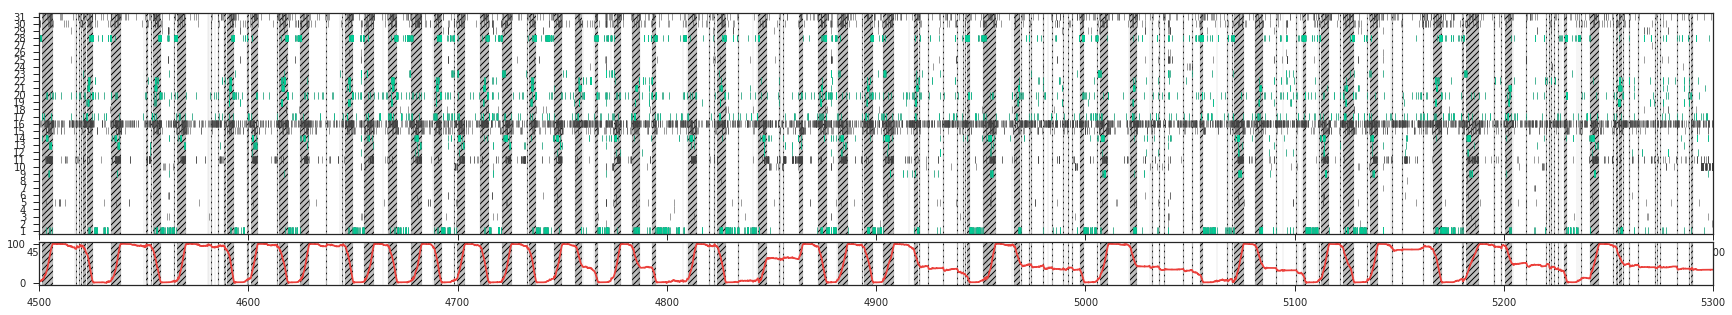

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with npl.FigureManager(show=True, figsize=(30,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.rasterplot(sta_placecells, lw=0.5, color=npl.colors.sweet.green)
    npl.epochplot(run_epochs)

    divider = make_axes_locatable(ax)

    axSpeed1d = divider.append_axes("bottom", size=0.6, pad=0.1)
    npl.plot(pos1d, ax=axSpeed1d)
    npl.epochplot(run_epochs, ax=axSpeed1d)

    xlims = (4500, 5300)

    ax.set_xlim(xlims)
    axSpeed1d.set_xlim(xlims)



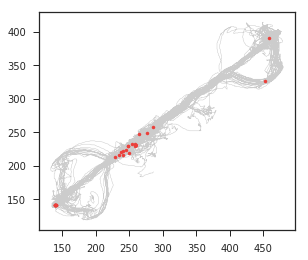

In [42]:
ax = npl.plot2d(pos, lw=0.5, c='0.8')
unit_id = 6
_, pos_at_spikes = pos.asarray(at=st[:,unit_id].time)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')

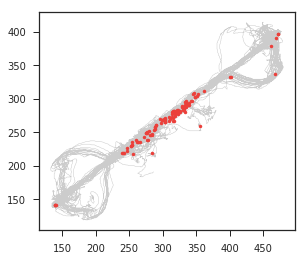

In [43]:
ax = npl.plot2d(pos, lw=0.5, c='0.8')
unit_id = 9
at = st.loc[:,unit_id][pos.support].time
_, pos_at_spikes = pos.asarray(at=at)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')